In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
import numpy as np
from utils.draw import draw_graph, draw_partition, draw_partition2, draw_partition3

In [3]:
def breadth_first(graph, root):
    
    #n is equal to the length of the X axis of the graph
    n = graph.shape[0]
    
    #the new_graph adjacency matrix is filled with -1's
    new_graph = -np.ones((n, n))
    
    #the level array is filled with -1's
    level = -np.ones(n,int)
    nodes = np.array(range(n))
    
    #setting initial values
    current_level = 0
    level[root] = current_level
    
    '''placing the graph into a breadth-first structure 
    and returning the converted graph'''
    while current_level in level:
        for node in nodes[level == current_level]:
            index = nodes[ (graph[node]>=0) & (level == -1)]
            new_graph[node,index] = 0
            new_graph[index,node] = 0
            level[index] = current_level + 1
        current_level += 1
    return new_graph, level

In [4]:
def pointer(new_graph, level, root):
    
    #n is equal to the length of the X axis of the graph
    n = new_graph.shape[0]
    
    #filling the output array with 0's
    output = np.zeros(n)
    
    #setting initial values
    output[root] = 1
    nodes = np.array(range(n))
    
    '''calculating the number of shortest paths to each node
    (shortest path = the sum of incoming paths)'''
    for x in range(int(level.max()+1)):
        for y in nodes[level == x]: 
            index = nodes[(new_graph[y] >= 0) & (level == x+1)]
            output[index] += output[y]
    return output

In [5]:
''' Determine the flow values from a starting node A to all other nodes in the network. 
This is done by working up from the lowest layers of the breadth-first search and dividing up the flow above a node 
in proportion to the number of shortest paths coming into it on each edge.'''
def flow(new_graph, level, root, output):
    
    n = new_graph.shape[0]
    nodes = np.array(range(n))
    flows = np.ones(n)
    
    for x in np.array(range(np.max(level)+1)[::-1]):
        for y in nodes[level == x]: 
            for i in nodes[(new_graph[y] >= 0) & (level == x-1)]:
                new_graph[i][y] = flows[y] * output[i] / output[y]
                new_graph[y][i] = flows[y] * output[i] / output[y]
                flows[i] += flows[y] * output[i] / output[y]

    return new_graph

In [6]:
def removeEdge(graph):
    max_edge = graph.max()
    graph[graph == max_edge] = -1       
    return graph

In [7]:
'''this graph categorizes nodes into discrete social groups,
separating them by colour'''
def categorize(graph):
    n = graph.shape[0]
    
    color = -np.ones(n, int) 
    current_color = 0
    nodes = np.array(range(n)) 
    
    while -1 in color:
        first = list(color).index(-1) 
        index = [first]
        color[index]= current_color
        
        while len(index) != 0:
            index2 = []
            for node in index:
                for i in range(n):
                    if graph[node][i]>=0 and color[i] == -1:
                        index2.append(i)
                        color[i] = current_color
            index = index2
        current_color += 1
        
    part = {}
    
    for i in range(len(color)):
        part[i] = color[i]
    
        
    return part

In [8]:
'''this function returns the graph after one step
of the Girvan-Newman method'''
def summary(graph,iterations):
    output = []
    graph[graph >= 0] = 0
    
    for y in range(iterations):

        for x in tqdm(range(graph.shape[0])):
            root = x

            breadth_first_value = breadth_first(graph, root)
            
            node_values = pointer(breadth_first_value[0], breadth_first_value[1], root)
            
            
            flow_values = flow(
                breadth_first_value[0],
                breadth_first_value[1],
                root,
                node_values)

            graph[flow_values >= 0] += flow_values[flow_values >= 0]

        graph = removeEdge(graph)
        graph[graph >= 0] = 0
        output.append(graph.copy())
    return output

In [9]:
#reading the .csv file
df = pd.read_csv('facebook_links.csv')

#the users set is the union between the first and second columns of users
users = set(df['out_f']).union(set(df['in_f']))

users = list(users) #converting the users set to a list
index = np.array(range(len(users)))

#creating a 2D adjacency matrix filled with -1's
graph = -np.ones((491,491))

#adding 0's to cells which represent a connection between nodes
for idx, row in df.iterrows():
    
    index1 = users.index(row['out_f'])
    index2 = users.index(row['in_f'])
    
    graph[index1][index2] = 0
    graph[index2][index1] = 0

In [10]:
'''This function translates the 2D adjacency matrix into 
a networkx representation which is used to draw the graph'''
def convert(graph):
    G = nx.Graph()
    G.add_nodes_from(list(range(graph.shape[0])))
    
    for x in range(graph.shape[0]):
        for y in range(x, graph.shape[0]):
            if graph[x][y] == 0:
                G.add_edge(x, y)
    return G

In [11]:
G = convert(graph)

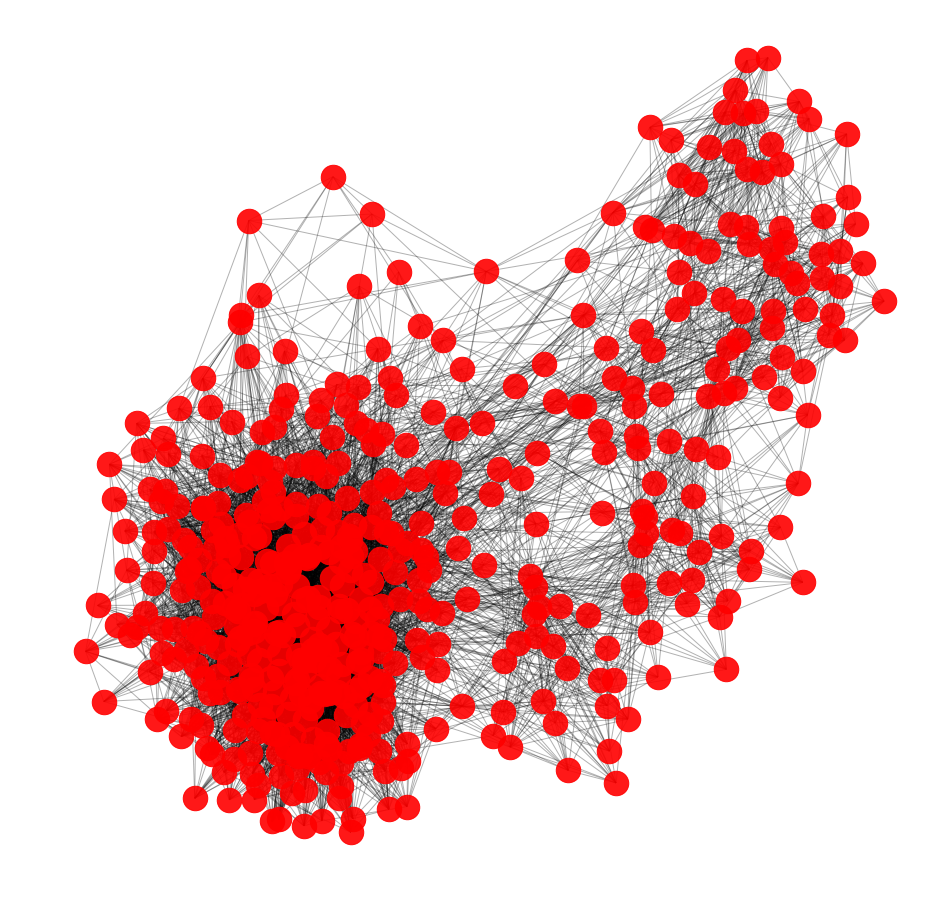

In [12]:
draw_graph(G) 

In [13]:
result = summary(graph,710)

100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:12<00:00, 39.10it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:12<00:00, 38.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:14<00:00, 34.48it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 89.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 89.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 99.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 97.77it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 103.43it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 109.43it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 114.07it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 114.89it/s]


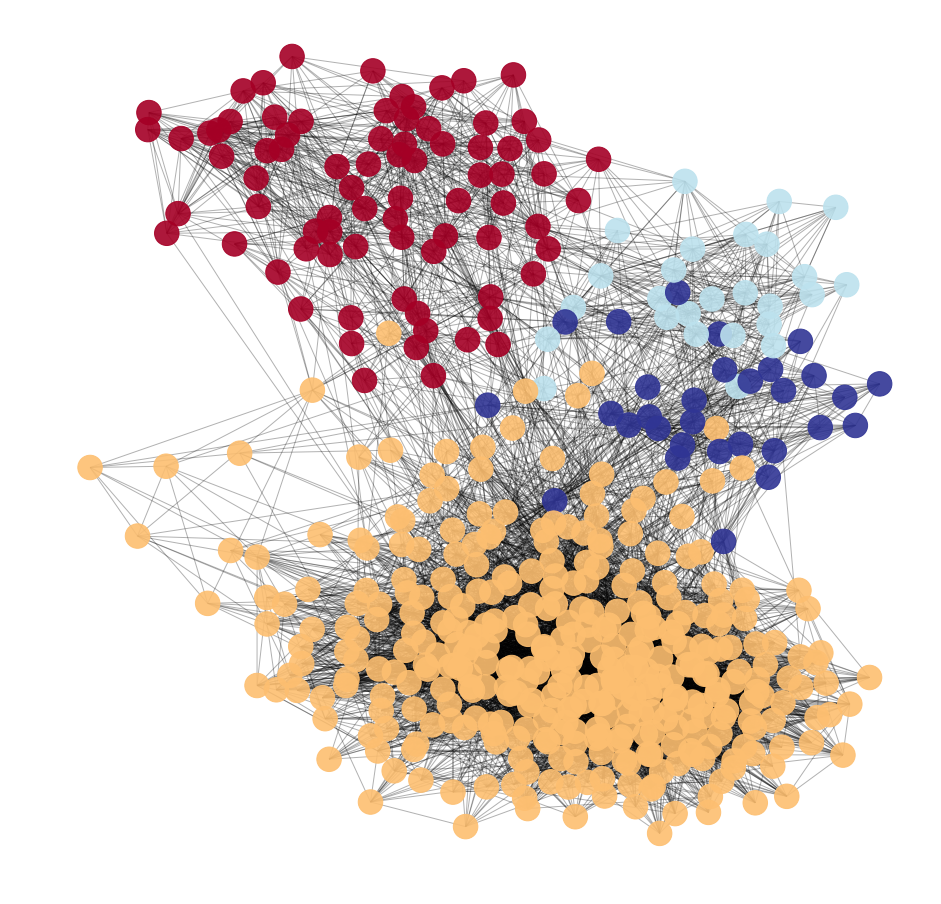

In [28]:
draw_partition2(convert(result[0]),categorize(result[528]))

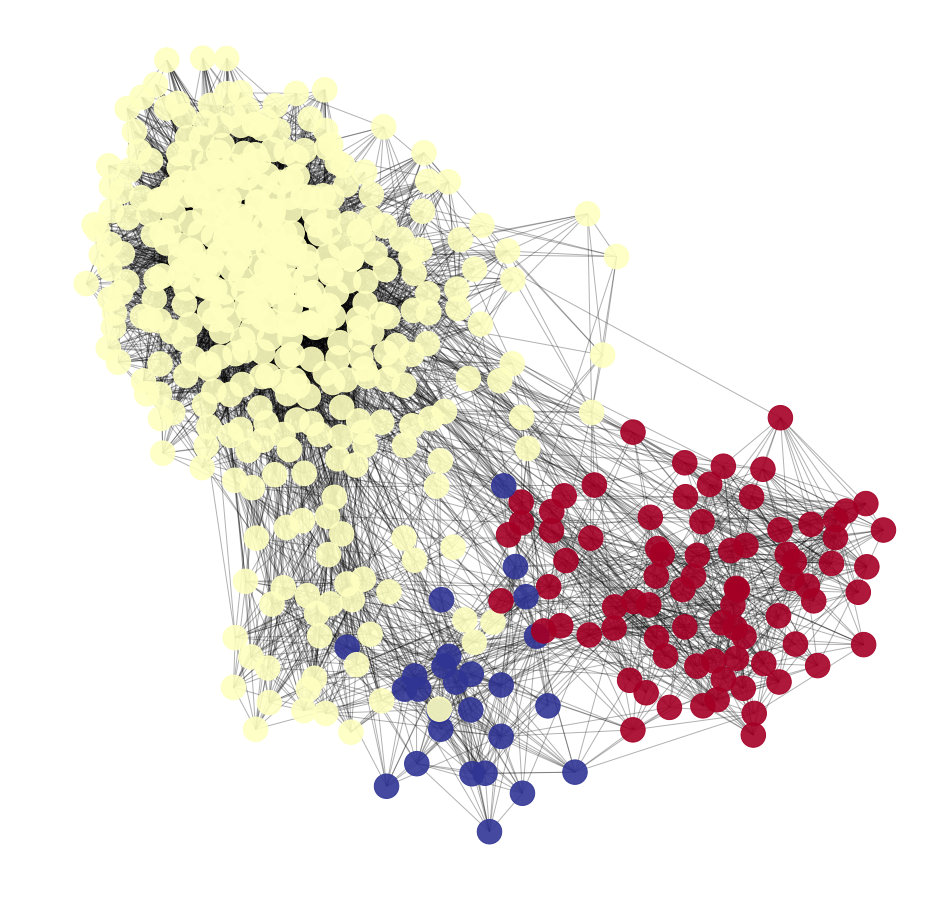

In [14]:
draw_partition2(convert(result[0]),categorize(result[510]))

In [15]:
#generating the "Karate Club" test network 
G = nx.karate_club_graph()

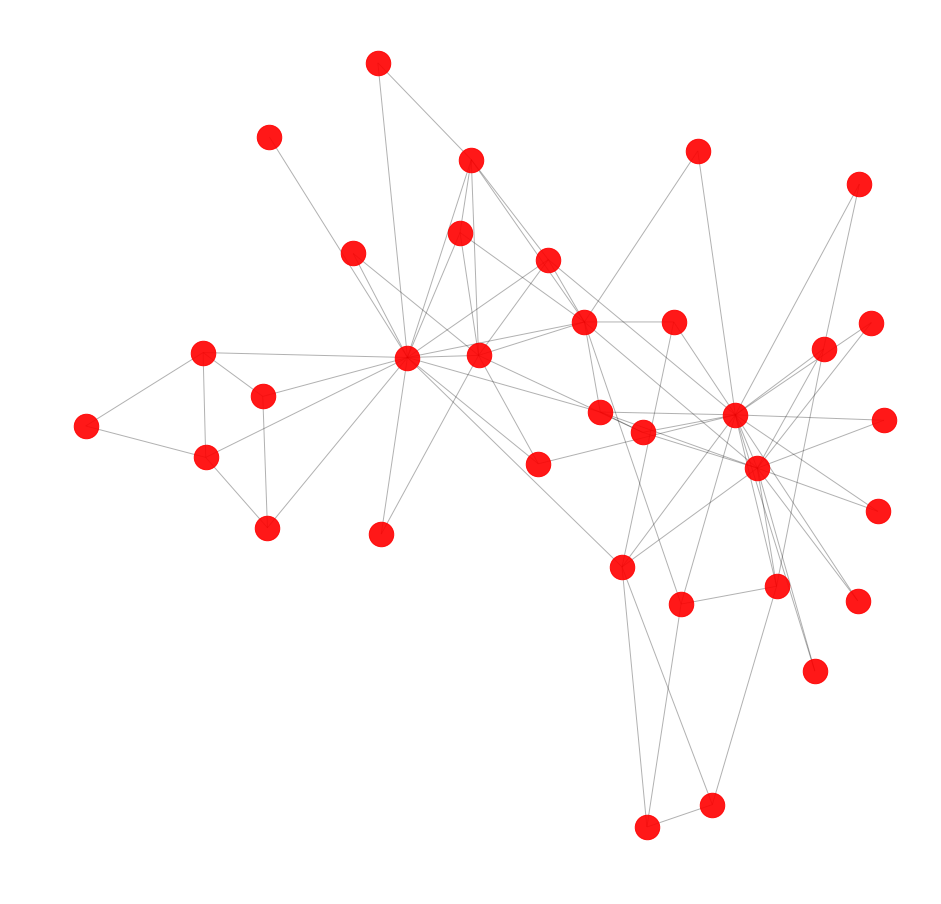

In [16]:
draw_graph(G)

In [17]:
#converting the "Karate Club" graph to a 2D adjacency matrix
G_adj =  nx.to_numpy_array(G)
G_adj[G_adj == 0] = -1
G_adj[G_adj>0] = 0
result2 = summary(G_adj,20)

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1701.58it/s]


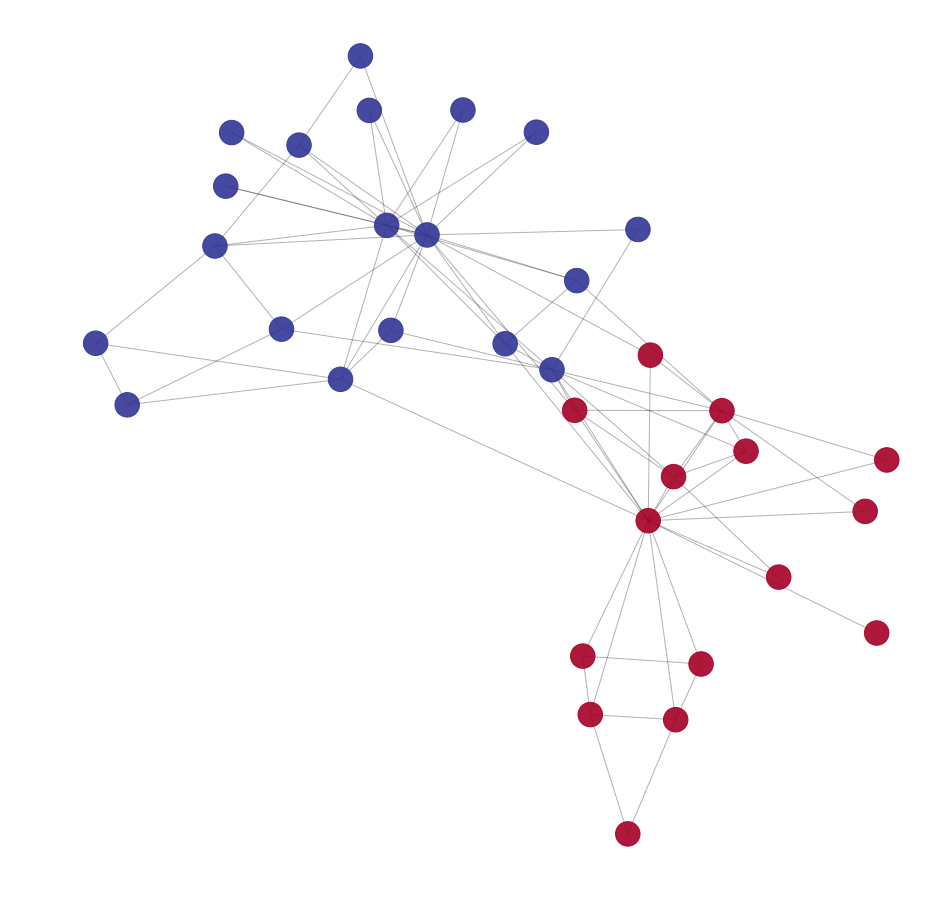

In [18]:
#drawing and categorizing the social groups in the graph
i = 10
draw_partition2(G,categorize(result2[i]))